# SBI eval 

In [22]:
# 100k sim - 1 hr

In [1]:
import time
from petitRADTRANS import Radtrans
import petitRADTRANS.retrieval_examples.emission.master_retrieval_model as rm
from petitRADTRANS import nat_cst as nc
import petitRADTRANS.rebin_give_width as rgw
from scipy.interpolate import interp1d
import sklearn

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

from torch.distributions import Independent, Distribution
from fab_priors import BoxUniform_New

import torch
from sbi.inference import SNRE_A, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi.types import Array, OneOrMore, ScalarFloat

#from Simulator import Simulator

In [2]:
op= '/home/mvasist/petitRADTRANS/petitRADTRANS/retrieval_examples/emission/'
observation_files = {}
observation_files['NIRISS SOSS'] = op +'NIRISS_SOSS_flux.dat'
observation_files['NIRSpec G395M'] = op +'NIRSpec_G395M_flux.dat'
observation_files['MIRI LRS'] = op +'MIRI_LRS_flux.dat'

# Wavelength range of observations, fixed parameters that will not be retrieved
WLENGTH = [0.3, 15.0]
# LOG_G =  2.58
R_pl =   1.84*nc.r_jup_mean
R_star = 1.81*nc.r_sun
gamma = 1
t_equ= 0

# Get host star spectrum to calculate F_pl / F_star later.
T_star = 6295.
x = nc.get_PHOENIX_spec(T_star)
fstar = interp1d(x[:,0], x[:,1])

In [3]:
####################################################################################
####################################################################################
### READ IN OBSERVATION
####################################################################################
####################################################################################

# Read in data, convert all to cgs! 

'''
Im using only data_flux_nu_error['MIRI LRS'] from here to calculate the likelihood. 
'''

data_wlen = {}
data_flux_nu = {}
data_flux_nu_error = {}
data_wlen_bins = {}

for name in observation_files.keys():
    print(name)
    dat_obs = np.genfromtxt(observation_files[name])
    data_wlen[name] = dat_obs[:,0]*1e-4
    data_flux_nu[name] = dat_obs[:,1]
    data_flux_nu_error[name] = dat_obs[:,2]
    
    data_wlen_bins[name] = np.zeros_like(data_wlen[name])
    data_wlen_bins[name][:-1] = np.diff(data_wlen[name])
    data_wlen_bins[name][-1] = data_wlen_bins[name][-2]

NIRISS SOSS
NIRSpec G395M
MIRI LRS


In [4]:
def Simulator(params): 

    NaN_spectra = 0

    atmosphere = Radtrans(line_species = ['H2O', 'CO_all_iso', \
                                         'CO2', 'CH4', \
                                          'Na', 'K'], \
          rayleigh_species = ['H2', 'He'], \
          continuum_opacities = ['H2-H2', 'H2-He'], \
          wlen_bords_micron = WLENGTH)#, mode='c-k')


    pressures = np.logspace(-6, 2, 100)
    atmosphere.setup_opa_structure(pressures)
    temperature = 1200. * np.ones_like(pressures)

    
    t_int = params[0].numpy()                             #200.
    log_kappa_IR = params[1].numpy()                      #-2
    log_gravity = params[2].numpy()                       #params[5].numpy() 1e1**2.45 

    gravity = np.exp(log_gravity)
    kappa_IR = np.exp(log_kappa_IR)
    
    temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, t_int, t_equ)
    
    abundances = {}
    abundances['H2'] = 0.75 * np.ones_like(temperature) #0.74 * np.ones_like(temperature) (params[3].numpy())
    abundances['He'] = 0.25 * np.ones_like(temperature)  #0.24 * np.ones_like(temperature) (params[4].numpy())
    abundances['H2O'] = 0.001 * np.ones_like(temperature)
    abundances['CO_all_iso'] = 0.01 * np.ones_like(temperature)
    abundances['CO2'] = 0.00001 * np.ones_like(temperature)
    abundances['CH4'] = 0.000001 * np.ones_like(temperature)
    abundances['Na'] = 0.00001 * np.ones_like(temperature)
    abundances['K'] = 0.000001 * np.ones_like(temperature)

    MMW = rm.calc_MMW(abundances) * np.ones_like(temperature)
    #print(MMW, abundances)
    
    atmosphere.calc_flux(temperature, abundances, gravity, MMW)

    wlen, flux_nu = nc.c/atmosphere.freq, atmosphere.flux/1e-6


    # Just to make sure that a long chain does not die
    # unexpectedly:
    # Return -inf if forward model returns NaN values
    if np.sum(np.isnan(flux_nu)) > 0:
        print("NaN spectrum encountered")
        NaN_spectra += 1
        return torch.ones([1,371])* -np.inf

    # Convert to observation for emission case
    flux_star = fstar(wlen)
    flux_sq   = flux_nu/flux_star*(R_pl/R_star)**2 

    flux_rebinned = rgw.rebin_give_width(wlen, flux_sq, \
                data_wlen['MIRI LRS'], data_wlen_bins['MIRI LRS'])

    #flux_rebinned = np.reshape(flux_rebinned, (371,1))    

    FR= torch.Tensor(flux_rebinned)
    
    return FR    


In [5]:
# Prior= utils.BoxUniform(low =torch.tensor([0., 0, 2.]), \
#                              high =torch.tensor([2., 4000, 3.7]))

In [6]:
Prior= utils.BoxUniform(low=torch.tensor([0., -4 , 2 ]), high=torch.tensor([2000., 0, 3.7 ]))

In [7]:
simulator, prior = prepare_for_sbi(Simulator, Prior)


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



In [8]:
inference = SNRE_A(prior= Prior, device= 'cpu', classifier='resnet')

In [10]:
#reading the csv file

# Xpd= pd.read_csv('X_1M.csv')
# Tpd= pd.read_csv('T_1M.csv')

X=[]
T=[]

# for i in range(1,11):
# #     print(i)
#     dfX= pd.read_csv('/home/mvasist/simulations/3_params/X_'+ str(i) + '.csv')
#     dfT= pd.read_csv('/home/mvasist/simulations/3_params/T_'+ str(i) + '.csv')
#     X.append(dfX.values)
#     T.append(dfT.values)
    
# for j in range(1,51):
#     dfX_= pd.read_csv('/home/mvasist/simulations/3_params/_X_'+ str(i) + '.csv')
#     dfT_= pd.read_csv('/home/mvasist/simulations/3_params/_T_'+ str(i) + '.csv')
#     X.append(dfX_.values)
#     T.append(dfT_.values)
    
# for k in range(1, 101):
#     dfX_M= pd.read_csv('/home/mvasist/simulations/3_params/X_1Msim_'+ str(k) + '.csv', low_memory = False) #chunksize=1000, iterator=True, dtype={'col2': np.float32}
#     dfT_M= pd.read_csv('/home/mvasist/simulations/3_params/T_1Msim_'+ str(k) + '.csv', low_memory = False)
#     X.append(dfX_M.values) #for x,t in zip(dfX_M,dfT_M):
#     T.append(dfT_M.values)


#log gamma, Tequ and log gravity 
for k in range(1, 101):
    if k==15: continue
    dfX_M= pd.read_csv('/home/mvasist/simulations/3_params/1/X_100ksim_TintLkIRLg'+ str(k) + '.csv', low_memory = False) #chunksize=1000, iterator=True, dtype={'col2': np.float32}
    dfT_M= pd.read_csv('/home/mvasist/simulations/3_params/1/T_100ksim_TintLkIRLg'+ str(k) + '.csv', low_memory = False)
    X.append(dfX_M.values) #for x,t in zip(dfX_M,dfT_M):
    T.append(dfT_M.values)


In [11]:
len(X)

99

In [12]:
# data = pd.read_csv(filepath, chunksize=1000, iterator=True) 
#Loop through the chunks and process the data
    
comb_np_array_X = np.vstack(X)
comb_np_array_T = np.vstack(T)



In [13]:
Xframe = pd.DataFrame(comb_np_array_X)
Tframe = pd.DataFrame(comb_np_array_T)



In [14]:
list_of_tensors_X = [torch.tensor(np.array(Xframe),dtype=torch.float32)]
list_of_tensors_T = [torch.tensor(np.array(Tframe),dtype=torch.float32)] #torch.tensor


In [15]:
XX = torch.cat(list_of_tensors_X)[:, 1:]
TT = torch.cat(list_of_tensors_T)[:,1:]

In [16]:
np.shape(XX)

torch.Size([98901, 371])

In [17]:
np.shape(TT)

torch.Size([98901, 3])

In [18]:
inference = inference.append_simulations(TT, XX)

In [ ]:
# 100k sim - epochs - 20 min

In [19]:
density_estimator = inference.train()

Neural network successfully converged after 55 epochs.


In [20]:
posterior = inference.build_posterior(density_estimator)

In [21]:
print(posterior)

Posterior conditional density p(θ|x) (amortized).

This RatioBasedPosterior-object was obtained with a SNRE_A-class method using a residualnet.
It provides MCMC to .sample() from the posterior and can evaluate the posterior density with .log_prob().


In [23]:
observation = torch.load('3param_observation_TintkIRLg.pt') #log_gamma, T_int, T_equ = 1.5, 750, 2000


In [25]:
# 100k samples is around 5 hours for 100k sim
# 100k samples is around 6 hours for 200k sim

#TintLkIRLg 100k sim: 10k sampl-23 min, 100ksampl-

#100k gmTequG- 5:41 hrs

In [ ]:
start = time.time()
sampls= 100000

samples = posterior.sample((sampls,), x=observation)
log_probability = posterior.log_prob(samples, x= observation)
end= time.time()
print('it takes: '+ str((end-start)/60) + ' min')

Generating samples:  40%|████      | 40250/100000 [1:37:53<2:19:28,  7.14it/s]

In [26]:
samples.size()
#log_probability.size()

torch.Size([10000, 3])

In [27]:
points = torch.cat([torch.ones(1)*750.,torch.ones(1)*-2.,torch.ones(1)*2.58])

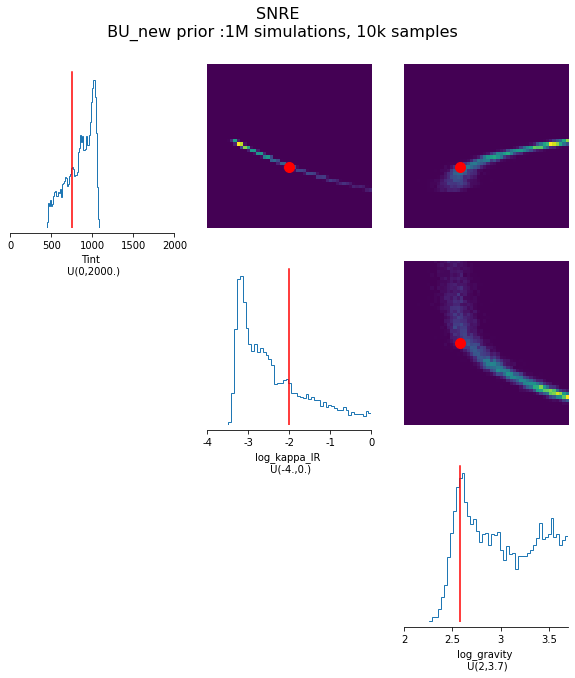

In [28]:
fig, axes = utils.pairplot(samples, points, limits=[[0,2000.],[-4.,0.],[2.0,3.7]], fig_size=(10,10), \
                           labels = ['Tint \n U(0,2000.)', 'log_kappa_IR \n U(-4.,0.)', 'log_gravity \n U(2,3.7)'],\
                           title= 'SNRE \n BU_new prior :' + str(1) + 'M simulations, '+ str(10) + 'k samples',\
                          points_colors = ['red'])

In [33]:
# Saving the samples file

df_samples = pd.DataFrame(samples.numpy())
df_samples.to_csv('/home/mvasist/samples/10ksamples__resnet_e113_SBI_1Msim_gammaTequG_modif.csv',mode='a', header=False)

df_lnprob = pd.DataFrame(log_probability.numpy())
df_lnprob.to_csv('/home/mvasist/samples/10klnprob__resnet_e113_SBI_1Msim_gammaTequG_modif.csv',mode='a', header=False)

In [ ]:
# resnet , mlp, linear

In [12]:
# saved samples 
ss=[]

#100klnprob_e76__SBI_200ksim.csv

for i in ['10']:  #'100', '50', 
    s= pd.read_csv('/home/mvasist/samples/'+ i +'ksamples_e96__SBI_100ksim_gammaTequG.csv')   #waiting for this to be saved 
    ss.append(s.values)

sss= np.vstack(ss)
samples = pd.DataFrame(sss)

#10ksamples_e96__SBI_100ksim_gammaTequG.csv


In [13]:
samples = torch.tensor(np.array(samples),dtype=torch.float32)

In [14]:
samples.size()

torch.Size([9999, 4])

In [15]:
points = torch.cat([torch.ones(1)*1.5,torch.ones(1)*2000.,torch.ones(1)*2.58])

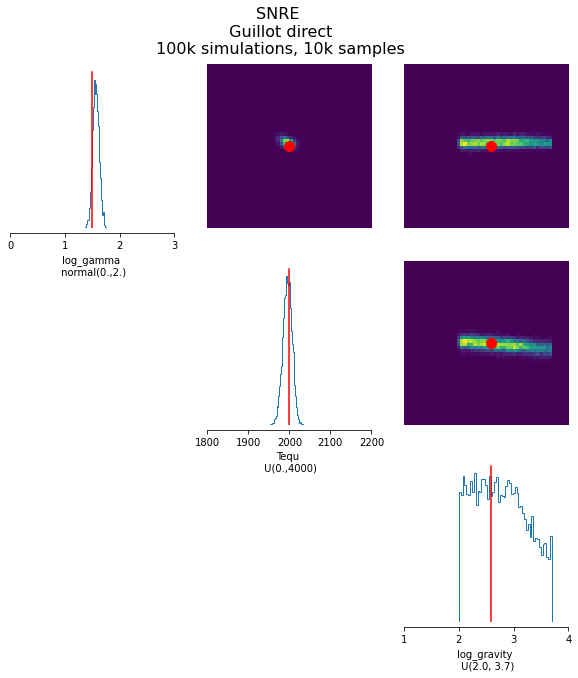

In [20]:
fig, axes = utils.pairplot(samples[:,1:], points, limits=[[0,3],[1800, 2200],[1, 4]], fig_size=(10,10), \
                           labels = ['log_gamma \n normal(0.,2.)', 'Tequ \n U(0.,4000)', 'log_gravity \n U(2.0, 3.7)'],\
                           title= 'SNRE \n Guillot direct \n' + str(100) + 'k simulations, '+ str(10) + 'k samples',\
                          points_colors = ['red'])

In [ ]:
# temp_params = {}
# temp_params['log_delta'] = -5.5
# temp_params['log_gamma'] = np.log10(0.4)
# temp_params['t_int'] = 750.
# temp_params['t_equ'] = 0.
# temp_params['log_p_trans'] = -3.
# temp_params['alpha'] = -0.25
# pressures, temperature = nc.make_press_temp(temp_params)

# # Create the Ratrans object here
# rt_object = Radtrans(line_species=['H2O', 'CO_all_iso', \
#                                          'CO2', 'CH4', \
#                                           'Na', 'K'], \
#                     rayleigh_species=['H2','He'], \
#                     continuum_opacities = ['H2-H2','H2-He'], \
#                     mode='c-k', \
#                     wlen_bords_micron=WLENGTH)

# # Create the RT arrays of appropriate lengths
# rt_object.setup_opa_structure(pressures)

# def Simulator(params): 
#     ##################

#     NaN_spectra = 0
    
#     log_gamma = params[0].numpy()                            #log(0.4)
#     t_equ = params[1].numpy()                                #1500.
#     log_gravity = params[2].numpy()                                #params[5] 2.45 
    
#     # Make dictionary for modified Guillot parameters
#     temp_params['log_gamma'] = log_gamma
#     temp_params['t_equ'] = t_equ
    
#     log_P0 = -2.                                      #params[6] 
  
#     gravity = np.exp(log_gravity)
#     P0 = np.exp(log_P0)
#     gamma = np.exp(log_gamma)

    
#     # Make dictionary for log 'metal' abundances    
#     abundances_metals = {}
        
#     abundances_metals['H2O'] = -3              #np.exp(params[7]) * np.ones_like(temperature)
#     abundances_metals['CO_all_iso'] = -2       #np.exp(params[8]) * np.ones_like(temperature)
#     abundances_metals['CO2'] = -5              #np.exp(params[9]) * np.ones_like(temperature)
#     abundances_metals['CH4'] = -6              #np.exp(params[10]) * np.ones_like(temperature)
#     abundances_metals['Na'] = -5               #np.exp(params[11]) * np.ones_like(temperature)
#     abundances_metals['K'] = -6                #np.exp(params[12]) * np.ones_like(temperature)
    
#     ####################################################################
#     ####################################################################

    
#     wlen, flux_nu = \
#             rm.retrieval_model_plain(rt_object, temp_params, log_gravity, \
#                                          log_P0, R_pl, abundances_metals)
    
#     # Just to make sure that a long chain does not die
#     # unexpectedly:
#     # Return -inf if forward model returns NaN values
#     if np.sum(np.isnan(flux_nu)) > 0:
#         print("NaN spectrum encountered")
#         NaN_spectra += 1
#         return -np.inf    

#     # Convert to observation for emission case
#     flux_star = fstar(wlen)
#     flux_sq   = flux_nu/flux_star*(R_pl/R_star)**2 
    
#     # Rebin model to observation
#     flux_rebinned = rgw.rebin_give_width(wlen, flux_sq, \
#                     data_wlen['MIRI LRS'], data_wlen_bins['MIRI LRS'])
    
#     FR= torch.Tensor(flux_rebinned)
        
#     return FR